# Solutions for Assignment 5: Exploring Yelp Reviews in Philadelphia

In this assignment, we'll explore restaurant review data available through the [Yelp Dataset Challenge](https://www.yelp.com/dataset). The dataset includes Yelp data for user reviews and business information for many metropolitan areas. I've already downloaded this dataset (8 GB total!) and extracted out the data files for reviews and restaurants in Philadelphia. I've placed these data files into the `data` directory in this repository. 

This assignment is broken into two parts:

**Part 1:** Analyzing correlations between restaurant reviews and census data

We'll explore the relationship between restaurant reviews and the income levels of the restaurant's surrounding area.

**Part 2:** Exploring the impact of fast food restaurants

We'll run a sentiment analysis on reviews of fast food restaurants and estimate income levels in neighborhoods with fast food restaurants. We'll test how well our sentiment analysis works by comparing the number of stars to the sentiment of reviews.


**Background readings**
- [Does sentiment analysis work?](http://varianceexplained.org/r/yelp-sentiment/)
- [The Geography of Taste: Using Yelp to Study Urban Culture](https://www.mdpi.com/2220-9964/7/9/376/pdf/1)

In [8]:
import pandas as pd
import geopandas as gpd
import altair as alt
import numpy as np

## 1. Correlating restaurant ratings and income levels

In this part, we'll use the census API to download household income data and explore how it correlates with restaurant review data.

### 1.1 Query the Census API

Use the `cenpy` package to download **median household income in the past 12 months** by census tract from the 2021 ACS 5-year data set for your county of interest.

You have two options to find the correct variable names:
- Search through: [https://api.census.gov/data/2021/acs/acs5/variables.html](https://api.census.gov/data/2021/acs/acs5/variables.html)
- Initialize an API connection and use the `.varslike()` function to search for the proper keywords 

At the end of this step, you should have a pandas DataFrame holding the income data for all census tracts within the county being analyzed. Feel free to rename your variable from the ACS so it has a more meaningful name!

::: {.callout-caution}
Some census tracts won't have any value because there are not enough households in that tract. The census will use a negative number as a default value for those tracts. You can safely remove those tracts from the analysis!
:::

In [9]:
import cenpy

/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Us

In [10]:
acs = cenpy.remote.APIConnection("ACSDT5Y2021")

In [11]:
matches = acs.varslike(
    pattern="household income",
    by="label",
).sort_index()

In [12]:
pd.set_option('display.max_colwidth', None)
matches.head(10)

,label,concept,predicateType,group,limit,predicateOnly,hasGeoCollectionSupport,attributes,required
B19013A_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE HOUSEHOLDER),int,B19013A,0,NaN,NaN,"B19013A_001EA,B19013A_001M,B19013A_001MA",NaN
B19013B_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER),int,B19013B,0,NaN,NaN,"B19013B_001EA,B19013B_001M,B19013B_001MA",NaN
B19013C_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (AMERICAN INDIAN AND ALASKA NATIVE ALONE HOUSEHOLDER),int,B19013C,0,NaN,NaN,"B19013C_001EA,B19013C_001M,B19013C_001MA",NaN
B19013D_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (ASIAN ALONE HOUSEHOLDER),int,B19013D,0,NaN,NaN,"B19013D_001EA,B19013D_001M,B19013D_001MA",NaN
B19013E_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE HOUSEHOLDER),int,B19013E,0,NaN,NaN,"B19013E_001EA,B19013E_001M,B19013E_001MA",NaN
B19013F_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (SOME OTHER RACE ALONE HOUSEHOLDER),int,B19013F,0,NaN,NaN,"B19013F_001EA,B19013F_001M,B19013F_001MA",NaN
B19013G_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (TWO OR MORE RACES HOUSEHOLDER),int,B19013G,0,NaN,NaN,"B19013G_001EA,B19013G_001M,B19013G_001MA",NaN
B19013H_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),"MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE, NOT HISPANIC OR LATINO HOUSEHOLDER)",int,B19013H,0,NaN,NaN,"B19013H_001EA,B19013H_001M,B19013H_001MA",NaN
B19013I_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS) (HISPANIC OR LATINO HOUSEHOLDER),int,B19013I,0,NaN,NaN,"B19013I_001EA,B19013I_001M,B19013I_001MA",NaN
B19013_001E,Estimate!!Median household income in the past 12 months (in 2021 inflation-adjusted dollars),MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS),int,B19013,0,NaN,NaN,"B19013_001EA,B19013_001M,B19013_001MA",NaN


In [13]:
variables = [
    "NAME",
    "B19013_001E" #median income in the past 12 month
]

In [14]:
philly_county_code = "101"
pa_state_code = "42"

philly_income = acs.query(cols=variables, geo_unit="block group:*", geo_filter={"state": pa_state_code, "county": philly_county_code, "tract": "*"}, apikey='b3abcecc231fa30ccaa18cb5e854c30f1982fe3f')
philly_income.head(10)

philly_income['B19013_001E'] = philly_income['B19013_001E'].replace('-666666666', '0').astype('int32')

In [15]:
philly_income.head()

,NAME,B19013_001E,state,county,tract,block group
0,"Block Group 1, Census Tract 1.01, Philadelphia County, Pennsylvania",0,42,101,000101,1
1,"Block Group 2, Census Tract 1.01, Philadelphia County, Pennsylvania",0,42,101,000101,2
2,"Block Group 3, Census Tract 1.01, Philadelphia County, Pennsylvania",0,42,101,000101,3
3,"Block Group 4, Census Tract 1.01, Philadelphia County, Pennsylvania",97210,42,101,000101,4
4,"Block Group 5, Census Tract 1.01, Philadelphia County, Pennsylvania",109269,42,101,000101,5


### 1.2 Download census tracts from the Census and merge the data from part 1.1

- Download census tracts for the desired geography using the `pygris` package
- Merge the downloaded census tracts with the household income DataFrame

In [16]:
import pygris
philly_blocks = pygris.block_groups(state=pa_state_code, county=philly_county_code, year=2021)

In [17]:
philly_merged = philly_blocks.merge(
    philly_income,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"],
    right_on=["state", "county", "tract", "block group"],)

In [18]:
philly_merged.head(1)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME,B19013_001E,state,county,tract,block group
0,42,101,989100,2,421019891002,Block Group 2,G5030,S,373653,7060,+40.0373207,-075.0177378,"POLYGON ((-75.02195 40.03435, -75.02191 40.03451, -75.02173 40.03482, -75.02151 40.03515, -75.02135 40.03544, -75.02129 40.03562, -75.02130 40.03582, -75.02134 40.03607, -75.02150 40.03638, -75.02163 40.03663, -75.02181 40.03702, -75.02168 40.03709, -75.01967 40.03813, -75.01902 40.03847, -75.01843 40.03877, -75.01783 40.03908, -75.01703 40.03950, -75.01621 40.03991, -75.01535 40.03894, -75.01500 40.03910, -75.01432 40.03945, -75.01254 40.03803, -75.01216 40.03772, -75.01195 40.03755, -75.01131 40.03704, -75.01225 40.03654, -75.01530 40.03485, -75.01790 40.03340, -75.01797 40.03336, -75.01817 40.03350, -75.01862 40.03366, -75.01959 40.03374, -75.01986 40.03376, -75.02000 40.03377, -75.02011 40.03377, -75.02022 40.03378, -75.02043 40.03379, -75.02083 40.03378, -75.02125 40.03374, -75.02142 40.03375, -75.02157 40.03381, -75.02173 40.03392, -75.02180 40.03401, -75.02189 40.03411, -75.02195 40.03422, -75.02195 40.03435))","Block Group 2, Census Tract 9891, Philadelphia County, Pennsylvania",0,42,101,989100,2


### 1.3 Load the restaurants data

The Yelp dataset includes data for 7,350 restaurants across the city. Load the data from the `data/` folder and use the `latitude` and `longitude` columns to create a GeoDataFrame after loading the JSON data. Be sure to set the right CRS on when initializing the GeoDataFrame!

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [19]:
data = pd.read_json("data/restaurants_philly.json.gz", orient='records', lines=True)
gpd_Data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude), crs="EPSG:4326")

In [20]:
gpd_Data.head()

,business_id,latitude,longitude,name,review_count,stars,categories,geometry
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,St Honore Pastries,80,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",POINT (-75.15556 39.95551)
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,Tuna Bar,245,4.0,"Sushi Bars, Restaurants, Japanese",POINT (-75.14323 39.95395)
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,BAP,205,4.5,"Korean, Restaurants",POINT (-75.16257 39.94322)
3,QdN72BWoyFypdGJhhI5r7g,39.939825,-75.157447,Bar One,65,4.0,"Cocktail Bars, Bars, Italian, Nightlife, Restaurants",POINT (-75.15745 39.93982)
4,Mjboz24M9NlBeiOJKLEd_Q,40.022466,-75.218314,DeSandro on Main,41,3.0,"Pizza, Restaurants, Salad, Soup",POINT (-75.21831 40.02247)


### 1.4 Add tract info for each restaurant

Do a spatial join to identify which census tract each restaurant is within. Make sure each dataframe has the same CRS!

At the end of this step, you should have a new dataframe with a column identifying the tract number for each restaurant.

In [21]:
tract_restaurant = gpd.sjoin(gpd_Data, philly_merged.loc[:,["geometry", "tract", "B19013_001E"]], how="left", op="within")
tract_restaurant = tract_restaurant.rename(columns={'B19013_001E': 'Median Household Income'})
tract_restaurant.head()

/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/q3/y0zpvj752qg3_3nvpkx6v2300000gn/T/ipykernel_14881/1177895681.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  tract_restaurant = gpd.sjoin(gpd_Data, philly_merged.loc[:,["geometry", "tract", "B19013_001E"]], how="left", op="within")


,business_id,latitude,longitude,name,review_count,stars,categories,geometry,index_right,tract,Median Household Income
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,St Honore Pastries,80,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",POINT (-75.15556 39.95551),988.0,000200,42308.0
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,Tuna Bar,245,4.0,"Sushi Bars, Restaurants, Japanese",POINT (-75.14323 39.95395),658.0,000102,198125.0
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,BAP,205,4.5,"Korean, Restaurants",POINT (-75.16257 39.94322),689.0,001500,107292.0
3,QdN72BWoyFypdGJhhI5r7g,39.939825,-75.157447,Bar One,65,4.0,"Cocktail Bars, Bars, Italian, Nightlife, Restaurants",POINT (-75.15745 39.93982),774.0,001800,103125.0
4,Mjboz24M9NlBeiOJKLEd_Q,40.022466,-75.218314,DeSandro on Main,41,3.0,"Pizza, Restaurants, Salad, Soup",POINT (-75.21831 40.02247),715.0,021000,86146.0


### 1.5 Add income data to your restaurant data

Add the income data to your dataframe from the previous step, merging the census data based on the tract that each restaurant is within.

In [ ]:
# this step is completed in 1.4

### 1.6 Make a plot of median household income vs. Yelp stars

Our dataset has the number of stars for each restaurant, rounded to the nearest 0.5 star. In this step, create a line plot that shows the average income value for each stars category (e.g., all restaurants with 1 star, 1.5 stars, 2 stars, etc.)

While their are multiple ways to do this, the [seaborn.lineplot()](https://seaborn.pydata.org/generated/seaborn.lineplot.html) is a great option. This can show the average value in each category as well as 95% uncertainty intervals. Use this function to plot the stars ("x") vs. average income ("y") for all of our restaurants, using the dataframe from last step. Be sure to format your figure to make it look nice!

**Question:** Is there a correlation between a restaurant's ratings and the income levels of its surrounding neighborhood?

In [22]:
stars = tract_restaurant.loc[:, ['stars','Median Household Income']].groupby(['stars']).median(['Median Household Income']).reset_index()

In [23]:
import seaborn as sns

<Axes: xlabel='stars', ylabel='Median Household Income'>

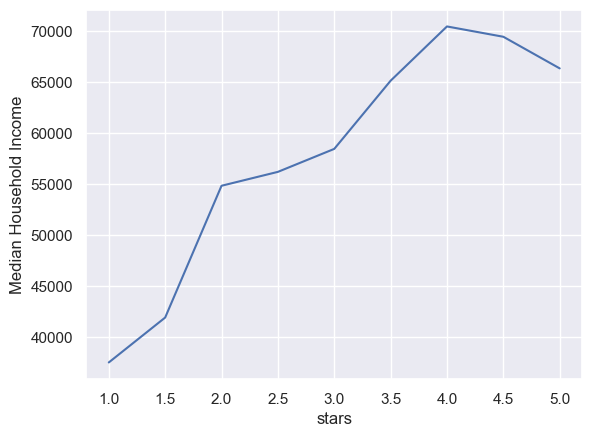

In [24]:
sns.set_theme()
sns.lineplot(data=stars, x="stars", y="Median Household Income")

As suggested by the graph above, there is an overall trend of higher ratings of restaurants associated with higeher median household income in the tracts that restaurants are located in.

## 2. Fast food trends in Philadelphia

At the end of part 1, you should have seen a strong trend where higher income tracts generally had restaurants with better reviews. In this section, we'll explore the impact of fast food restaurants and how they might be impacting this trend. 

**Hypothesis**

1. Fast food restaurants are predominantly located in areas with lower median income levels. 
1. Fast food restaurants have worse reviews compared to typical restaurants. 

If true, these two hypotheses could help to explain the trend we found in part 1. Let's dive in and test our hypotheses!

### 2.1 Identify fast food restaurants

The "categories" column in our dataset contains multiple classifications for each restaurant. One such category is "Fast Food". In this step, add a new column called "is_fast_food" that is `True` if the "categories" column contains the term "Fast Food" and `False` otherwise

In [25]:
tract_restaurant['is_fast_food'] = tract_restaurant['categories'].str.contains('Fast Food')

### 2.2 Calculate the median income for fast food and otherwise

Group by the "is_fast_food" column and calculate the median income for restaurants that are and are not fast food. You should find that income levels are lower in tracts with fast food.

*Note:* this is just an estimate, since we are calculating a median of median income values.

In [26]:
fastfood_income = tract_restaurant.loc[:, ['is_fast_food','Median Household Income']].groupby(['is_fast_food']).median(['Median Household Income']).reset_index()
fastfood_income

,is_fast_food,Median Household Income
0,False,66290.0
1,True,46668.0


### 2.3 Load fast food review data

In the rest of part 2, we're going to run a sentiment analysis on the reviews for fast food restaurants. 
The review data for all fast food restaurants identified in part 2.1 is already stored in the `data/` folder. The data is stored as a JSON file and you can use `pandas.read_json` to load it. 

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [27]:
reviews = pd.read_json("data/reviews_philly_fast_food.json.gz", orient='records',lines=True)
reviews.head()

,business_id,review_id,stars,text
0,kgMEBZG6rjkGeFzPaIM4MQ,E-yGr1OhsUBxNeUVLDVouA,1,"I know I shouldn't expect much but everything I asked for that was on the drive thru menu was not available. I was actually afraid of what I was going to get once I did get it. I saw the movie ""waiting"". Word of advice stay clear of this arch. Just so you know I was only trying to order a beverage how pathetic is that."
1,FKrP06TDAKtxNG1vrRQcQQ,0IpFZoaY_RRNjha8Q_Wz6w,2,"Perfect place to go if you like waiting 20 minutes at the counter and getting dirty looks from the waiters while you're waiting for service. My friend and I made the mistake of coming here after being famished after a long day. Hey Johnny Rockets, I understand that you guys can get busy, but a quick acknowledgment that we existed would have sufficed. After finally waving down a waitress, we finally got a menu with a heavy sigh on the side as if we were troubling the staff. I urged my friend that we should probably leave, but we had already waited long enough, so I reluctantly ordered.\nI got the original burger and fries as did my friend as per usual. Don't get me wrong, the burgers and fries are decent but definitely not worth the wait or hassle. Even the chocolate shake that I ordered was pretty good with a good consistency, but the taste of bad service still lingered and eventually overpowered the chocolate flavored concoction. Needless to say, I will definitely not be coming back to this location if it continues to be managed so rudely."
2,w9hS5x1F52Id-G1KTrAOZg,0KlwfaHZyvao41_3S47dyg,2,Was not a fan of their cheesesteak. Their wiz sauce was mustard based and it was not terrible as a sandwich itself but mustard is not the flavor one expects or wants in a cheesesteak. It was overwhelming and not good.
3,fr2qDm_mY1afIGMvqsKUCg,oKSUOq7pCQzyypFDSa1HoA,3,"Ok this is an aberration from my city foodie reviews but I figured I'll take the time and review some of the local establishments that I order from on a consistent base while working in Bensalem, P.A. Without further adieu...\nGeorge's Chix is good. I'm always satisfied with the food and value each and every time. I haven't branched out seeking much more than a good deal each time and trust me I'm not looking to find the healthiest option on the menu (usually I get the nugget/fries/soda deal, the chix fingers/fries/soda deal, or Ceasar wrap/fries/soda deal- $8 or $9 after a nice tip) but the food is alright.\nGive George's a try if you're in town and looking to get down on some fried grub!"
4,fr2qDm_mY1afIGMvqsKUCg,6SMUmb7Npwnq6AusxqOXzQ,5,"My family has been customers of George's for years. You pay for what you get. The quality of the food is premier and they don't hold back on portion size. Their cheesesteaks are amazing (chopped steak) and their chicken cheesesteaks are made from the same chicken as their Char platters, which is legit. Their Char platters come with some of the best and juciest grilled chicken I've ever had. They make their own sauce, so just that alone puts their wings above the other restaurants in the neighborhood that just use Franks Red Hot. I have yet to have something on their menu that I didn't like."


### 2.4 Trim to the most popular fast food restaurants

There's too many reviews to run a sentiment analysis on all of them in a reasonable time. Let's trim our reviews dataset to the most popular fast food restaurants, using the list provided below.

You will need to get the "business_id" values for each of these restaurants from the restaurants data loaded in part 1.3. Then, trim the reviews data to include reviews only for those business IDs.

In [28]:
popular_fast_food = [
    "McDonald's",
    "Wendy's",
    "Subway",
    "Popeyes Louisiana Kitchen",
    "Taco Bell",
    "KFC",
    "Burger King",
]

In [29]:
pop_fast_food = tract_restaurant[tract_restaurant['name'].isin(popular_fast_food)]
selected_reviews = reviews[reviews['business_id'].isin(pop_fast_food['business_id'])]
selected_reviews.head()

,business_id,review_id,stars,text
0,kgMEBZG6rjkGeFzPaIM4MQ,E-yGr1OhsUBxNeUVLDVouA,1,"I know I shouldn't expect much but everything I asked for that was on the drive thru menu was not available. I was actually afraid of what I was going to get once I did get it. I saw the movie ""waiting"". Word of advice stay clear of this arch. Just so you know I was only trying to order a beverage how pathetic is that."
8,PjknD8uD_0tisZQbomiYoQ,6TqKBa-HDiq2_W_ip2AItA,5,I am only giving 5 stars because the Shamrock Shake is back and delicious!! Too bad it's around only once a year ;(
13,kgMEBZG6rjkGeFzPaIM4MQ,NGaXI03qbtBLshjfJV4pbQ,3,"Dirty bathrooms and very slow service, but I was pleased because they had a TV on with subtitles and the volume on, and it was turned to the news! A good place to pass some time with a tasty Mc-snack and a hot coffee while in Philly during a chilly day! We stopped here on the way to a football game and found it a very pleasant and relaxing place to hang out for a while."
17,LACylKxImNI29DKUQpWuHw,HHy9yIjW07VHUE6nXVbsVA,3,Burger King is an okay alternative to Mcdonalds. 6/10 Would recommend but idk about coming again.
21,gq4zw-ru_rkZ2UBIanaZFQ,yMZTK5B_0SAdUXSrIkXrmA,1,ive tried going here four times with no success because the drive tru takes so long that i have pulled away every single time. great job idiots!


### 2.5 Run the emotions classifier on fast food reviews

Run a sentiment analysis on the reviews data from the previous step. Use the [DistilBERT model](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) that can predict emotion labels (anger, fear, sadness, joy, love, and surprise). Transform the result from the classifier into a DataFrame so that you have a column for each of the emotion labels.

In [3]:
from transformers import pipeline

2023-11-11 21:15:57.312117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

inputs = tokenizer("Hello, my daog is cute", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'LABEL_0'

In [41]:
# The model
model = "bhadresh-savani/distilbert-base-uncased-emotion"

# Initialize our sentiment analyzer
emotion_classifier = pipeline(
    task="text-classification",  # The task we are doing
    model=model,  # The specific model name
    top_k=None,  # Predict all labels, not just top ones
    tokenizer=model,  # Tokenize inputs using model tokenizer
    truncation=True,  # Truncate text if we need to
)

In [33]:
review = selected_reviews['text'].str.strip().tolist()

In [48]:
%%time
scores = emotion_classifier(review)

CPU times: user 11min 18s, sys: 19.7 s, total: 11min 38s
Wall time: 2min 56s


In [49]:
scores[0]

[{'label': 'sadness', 'score': 0.7338692545890808},
 {'label': 'fear', 'score': 0.2506760060787201},
 {'label': 'anger', 'score': 0.011038999073207378},
 {'label': 'joy', 'score': 0.0027580487076193094},
 {'label': 'surprise', 'score': 0.0010148979490622878},
 {'label': 'love', 'score': 0.0006427845801226795}]

In [50]:
emo = pd.DataFrame([{d["label"]: d["score"] for d in dd} for dd in scores]).assign(
    text=review
)
emo.head()

,sadness,fear,anger,joy,surprise,love,text
0,0.733869,0.250676,0.011039,0.002758,0.001015,0.000643,"I know I shouldn't expect much but everything I asked for that was on the drive thru menu was not available. I was actually afraid of what I was going to get once I did get it. I saw the movie ""waiting"". Word of advice stay clear of this arch. Just so you know I was only trying to order a beverage how pathetic is that."
1,0.000230,0.000126,0.000165,0.998759,0.000246,0.000475,I am only giving 5 stars because the Shamrock Shake is back and delicious!! Too bad it's around only once a year ;(
2,0.000216,0.000088,0.000153,0.998563,0.000161,0.000819,"Dirty bathrooms and very slow service, but I was pleased because they had a TV on with subtitles and the volume on, and it was turned to the news! A good place to pass some time with a tasty Mc-snack and a hot coffee while in Philly during a chilly day! We stopped here on the way to a football game and found it a very pleasant and relaxing place to hang out for a while."
3,0.000838,0.000403,0.000811,0.996928,0.000140,0.000880,Burger King is an okay alternative to Mcdonalds. 6/10 Would recommend but idk about coming again.
4,0.005284,0.000753,0.006195,0.985421,0.001620,0.000726,ive tried going here four times with no success because the drive tru takes so long that i have pulled away every single time. great job idiots!


### 2.6 Identify the predicted emotion for each text

Use the pandas [idxmax()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html) to identify the predicted emotion for each review, and add this value to a new column called "prediction"

The predicted emotion has the highest confidence score across all emotion labels for a particular label.

In [51]:
emo_labels = ["anger", "fear", "sadness", "joy", "surprise", "love"]
emo['prediction'] = emo[emo_labels].idxmax(axis=1)
emo.head()

,sadness,fear,anger,joy,surprise,love,text,prediction
0,0.733869,0.250676,0.011039,0.002758,0.001015,0.000643,"I know I shouldn't expect much but everything I asked for that was on the drive thru menu was not available. I was actually afraid of what I was going to get once I did get it. I saw the movie ""waiting"". Word of advice stay clear of this arch. Just so you know I was only trying to order a beverage how pathetic is that.",sadness
1,0.000230,0.000126,0.000165,0.998759,0.000246,0.000475,I am only giving 5 stars because the Shamrock Shake is back and delicious!! Too bad it's around only once a year ;(,joy
2,0.000216,0.000088,0.000153,0.998563,0.000161,0.000819,"Dirty bathrooms and very slow service, but I was pleased because they had a TV on with subtitles and the volume on, and it was turned to the news! A good place to pass some time with a tasty Mc-snack and a hot coffee while in Philly during a chilly day! We stopped here on the way to a football game and found it a very pleasant and relaxing place to hang out for a while.",joy
3,0.000838,0.000403,0.000811,0.996928,0.000140,0.000880,Burger King is an okay alternative to Mcdonalds. 6/10 Would recommend but idk about coming again.,joy
4,0.005284,0.000753,0.006195,0.985421,0.001620,0.000726,ive tried going here four times with no success because the drive tru takes so long that i have pulled away every single time. great job idiots!,joy


### 2.7 Combine the ratings and sentiment data

Combine the data from part 2.4 (reviews data) and part 2.6 (emotion data). Use the `pd.concat()` function and combine along the column axis.

**Note:** You'll need to reset the index of your reviews data frame so it matches the emotion data index (it should run from 0 to the length of the data - 1).


In [56]:
combined = pd.concat([selected_reviews.reset_index(), emo], axis=1)
combined.head()

,index,business_id,review_id,stars,text,sadness,fear,anger,joy,surprise,love,text,prediction
0,0,kgMEBZG6rjkGeFzPaIM4MQ,E-yGr1OhsUBxNeUVLDVouA,1,"I know I shouldn't expect much but everything I asked for that was on the drive thru menu was not available. I was actually afraid of what I was going to get once I did get it. I saw the movie ""waiting"". Word of advice stay clear of this arch. Just so you know I was only trying to order a beverage how pathetic is that.",0.733869,0.250676,0.011039,0.002758,0.001015,0.000643,"I know I shouldn't expect much but everything I asked for that was on the drive thru menu was not available. I was actually afraid of what I was going to get once I did get it. I saw the movie ""waiting"". Word of advice stay clear of this arch. Just so you know I was only trying to order a beverage how pathetic is that.",sadness
1,8,PjknD8uD_0tisZQbomiYoQ,6TqKBa-HDiq2_W_ip2AItA,5,I am only giving 5 stars because the Shamrock Shake is back and delicious!! Too bad it's around only once a year ;(,0.000230,0.000126,0.000165,0.998759,0.000246,0.000475,I am only giving 5 stars because the Shamrock Shake is back and delicious!! Too bad it's around only once a year ;(,joy
2,13,kgMEBZG6rjkGeFzPaIM4MQ,NGaXI03qbtBLshjfJV4pbQ,3,"Dirty bathrooms and very slow service, but I was pleased because they had a TV on with subtitles and the volume on, and it was turned to the news! A good place to pass some time with a tasty Mc-snack and a hot coffee while in Philly during a chilly day! We stopped here on the way to a football game and found it a very pleasant and relaxing place to hang out for a while.",0.000216,0.000088,0.000153,0.998563,0.000161,0.000819,"Dirty bathrooms and very slow service, but I was pleased because they had a TV on with subtitles and the volume on, and it was turned to the news! A good place to pass some time with a tasty Mc-snack and a hot coffee while in Philly during a chilly day! We stopped here on the way to a football game and found it a very pleasant and relaxing place to hang out for a while.",joy
3,17,LACylKxImNI29DKUQpWuHw,HHy9yIjW07VHUE6nXVbsVA,3,Burger King is an okay alternative to Mcdonalds. 6/10 Would recommend but idk about coming again.,0.000838,0.000403,0.000811,0.996928,0.000140,0.000880,Burger King is an okay alternative to Mcdonalds. 6/10 Would recommend but idk about coming again.,joy
4,21,gq4zw-ru_rkZ2UBIanaZFQ,yMZTK5B_0SAdUXSrIkXrmA,1,ive tried going here four times with no success because the drive tru takes so long that i have pulled away every single time. great job idiots!,0.005284,0.000753,0.006195,0.985421,0.001620,0.000726,ive tried going here four times with no success because the drive tru takes so long that i have pulled away every single time. great job idiots!,joy


### 2.8 Plot sentiment vs. stars

We now have a dataframe with the predicted primary emotion for each review and the associated number of stars for each review. Let's explore two questions:

1. Does sentiment analysis work? Do reviews with fewer stars have negative emotions?
1. For our fast food restaurants, are reviews generally positive or negative? 

Use seaborn's [histplot()](https://seaborn.pydata.org/generated/seaborn.histplot.html) to make a stacked bar chart showing the breakdown of each emotion for each stars category (1 star, 2 stars, etc.). A few notes:

- To stack multiple emotion labels in one bar, use the `multiple="stack"` keyword
- The `discrete=True` can be helpful to tell seaborn our stars values are discrete categories


<Axes: xlabel='stars', ylabel='Count'>

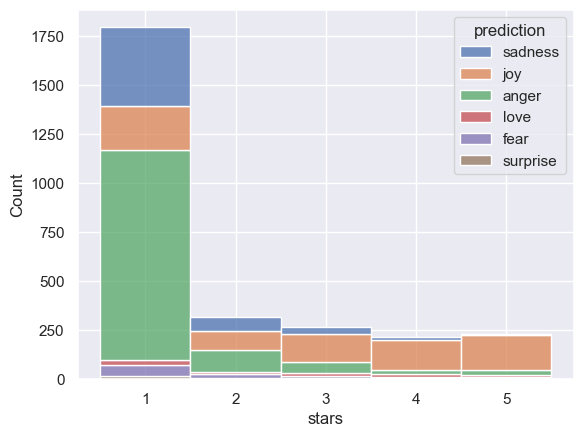

In [58]:
sns.set_theme()
sns.histplot(data=combined, x="stars", hue="prediction", multiple="stack", discrete=True)

**Question:** What does your chart indicate for the effectiveness of our sentiment analysis? Does our original hypothesis about fast food restaurants seem plausible?

The chart indicates two important pieces of information -- 1) disproportionally large number of reviews on fast food restaurants are 1-star; 2) based on results from sentiment analysis, highly rated reviews usually reflects joy, while 1-star reviews largely reflects sadness and anger, despite a small portion reflecting joy. 